# Trend Classification with LSTM

### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=30
predict_length = 5
time_period = '6y'

# 1.0 Load data

## 1.1 Load stock data

In [3]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [4]:
traditional_energy_stocks = [ "LNG", "OKE", "BKR", "WMB", "EQT",  "XEC",  "XOM",  "CVX",  "BP",  "OXY",  "COP",  "EOG",  "COG",  "CNQ",  "SLB",  "PTR",  "TOT",  "ENB"]

In [5]:
data = get_data_yf(traditional_energy_stocks + top_energy, time_period)

[*********************100%***********************]  33 of 33 completed


In [6]:
data.isna().sum().sum()

0

In [7]:
data = process_stock_data_from_yf(data)

In [8]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

## 1.2 Compute technical indicators

In [9]:
all_stock_features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']

In [10]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

## 1.3 Load trends data

In [11]:
filenames = [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [12]:
climate_trends_data = load_climate_data(filenames, terms)

In [13]:
climate_trends_data.shape

(2278, 11)

<AxesSubplot:xlabel='Date'>

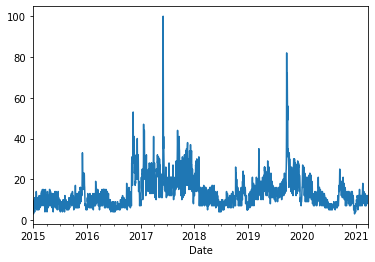

In [14]:
climate_trends_data.set_index('Date')[terms[0]].plot()

### Choose features

In [15]:
chosen_stock_features = ['Close', 'High',
 'Low', 
'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 
'WMA', 
'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 
'ADX',
 'ROC', 'MACD', 'CCI'
                        ]

In [16]:
chosen_trend_terms = [
#     "climate change",
#     "greenhouse gas",
#     "oil",
#     "renewable",
#     "carbon tax",
#     "electric vehicles",
# #     "environmental protection agency",
#     "fossil fuels",
# #     "fracking",
#     "global warming",
]

# 3.0 Model design

In [17]:
num_features = len(chosen_stock_features) + len(chosen_trend_terms) 

In [18]:
reg = 0.002
drop=0.5

model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))
model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(Flatten())

model.add(Dense(5, activation='relu', activity_regularizer=l2(reg)))
model.add(Dropout(drop))


model.add(Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 75)            31500     
_________________________________________________________________
dropout (Dropout)            (None, 30, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 30)            7

# 2.0 Prepare dataset of many stocks

In [20]:
x_train, y_train, x_valid, y_valid, x_test, y_test = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           traditional_energy_stocks + top_energy,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [21]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (22110, 30, 29)
y_train: (22110,)
x_valid: (7128, 30, 29)
y_valid (7128,)
x_test: (7131, 30, 29)
y_test (7131,)


## 2.1 Train on many stocks

In [22]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [24]:
history1 = model.fit(x_train, 
                     y_train, 
                     epochs=15, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
346/346 [==============================] - 15s 29ms/step - loss: 0.7059 - accuracy: 0.5161 - val_loss: 0.6983 - val_accuracy: 0.5136
Epoch 2/15
346/346 [==============================] - 7s 20ms/step - loss: 0.6930 - accuracy: 0.5169 - val_loss: 0.6979 - val_accuracy: 0.5011
Epoch 3/15
346/346 [==============================] - 7s 20ms/step - loss: 0.6930 - accuracy: 0.5215 - val_loss: 0.6964 - val_accuracy: 0.5136
Epoch 4/15
346/346 [==============================] - 7s 20ms/step - loss: 0.6924 - accuracy: 0.5202 - val_loss: 0.6964 - val_accuracy: 0.5081
Epoch 5/15
346/346 [==============================] - 7s 20ms/step - loss: 0.6924 - accuracy: 0.5198 - val_loss: 0.6990 - val_accuracy: 0.4983
Epoch 6/15
346/346 [==============================] - 7s 20ms/step - loss: 0.6918 - accuracy: 0.5271 - val_loss: 0.6989 - val_accuracy: 0.5015
Epoch 7/15
346/346 [==============================] - 7s 20ms/step - loss: 0.6915 - accuracy: 0.5299 - val_loss: 0.7498 - val_accuracy: 0.491

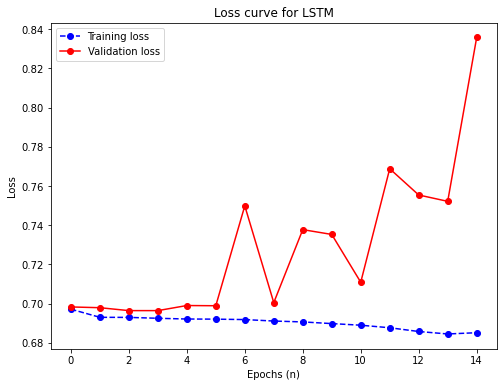

In [25]:
plot_loss(history1)

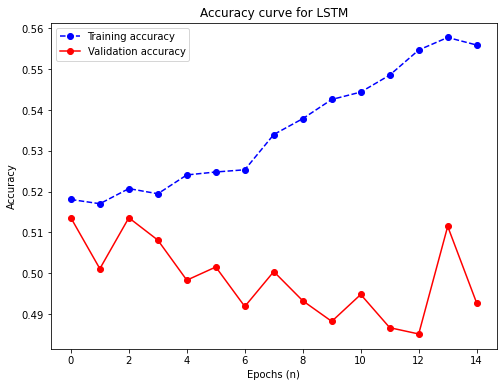

In [26]:
plot_acc(history1)

## 2.2 Performance of model

In [27]:
performance_stats(model, x_train, y_train)

Upward ratio: 51.68%
Mean prediction: 49.93%
Predicted upward ratio: 54.57%
Accuracy: 57.91%


In [28]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 51.36%
Mean prediction: 40.49%
Predicted upward ratio: 20.30%
Accuracy: 49.27%


In [29]:
performance_stats(model, x_test, y_test)

Upward ratio: 46.53%
Mean prediction: 47.17%
Predicted upward ratio: 38.76%
Accuracy: 50.86%


# 3.0 Prepare data for less stocks

In [30]:
x_train2, y_train2, x_valid2, y_valid2, x_test2, y_test2 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           traditional_energy_stocks,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [31]:
print("x_train: {}".format(x_train2.shape))
print("y_train: {}".format(y_train2.shape))
print("x_valid: {}".format(x_valid2.shape))
print("y_valid {}".format(y_valid2.shape))
print("x_test: {}".format(x_test2.shape))
print("y_test {}".format(y_test2.shape))

x_train: (12060, 30, 29)
y_train: (12060,)
x_valid: (3888, 30, 29)
y_valid (3888,)
x_test: (3876, 30, 29)
y_test (3876,)


## 3.1 Train model on less stocks

In [32]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [35]:
history2 = model.fit(x_train2, 
                     y_train2, 
                     epochs=8, 
                     validation_data=(x_valid2, y_valid2), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/8
189/189 [==============================] - 14s 48ms/step - loss: 0.6878 - accuracy: 0.5411 - val_loss: 0.8257 - val_accuracy: 0.4874
Epoch 2/8
189/189 [==============================] - 4s 20ms/step - loss: 0.6814 - accuracy: 0.5692 - val_loss: 0.8155 - val_accuracy: 0.4866
Epoch 3/8
189/189 [==============================] - 4s 20ms/step - loss: 0.6800 - accuracy: 0.5760 - val_loss: 0.8364 - val_accuracy: 0.4877
Epoch 4/8
189/189 [==============================] - 4s 20ms/step - loss: 0.6833 - accuracy: 0.5625 - val_loss: 0.8356 - val_accuracy: 0.4812
Epoch 5/8
189/189 [==============================] - 4s 20ms/step - loss: 0.6826 - accuracy: 0.5574 - val_loss: 0.9040 - val_accuracy: 0.4874
Epoch 6/8
189/189 [==============================] - 4s 20ms/step - loss: 0.6794 - accuracy: 0.5669 - val_loss: 0.8497 - val_accuracy: 0.4897
Epoch 7/8
189/189 [==============================] - 4s 19ms/step - loss: 0.6791 - accuracy: 0.5727 - val_loss: 0.8557 - val_accuracy: 0.5028
Epoch

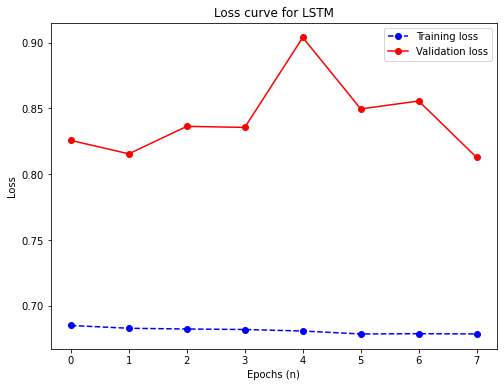

In [36]:
plot_loss(history2)

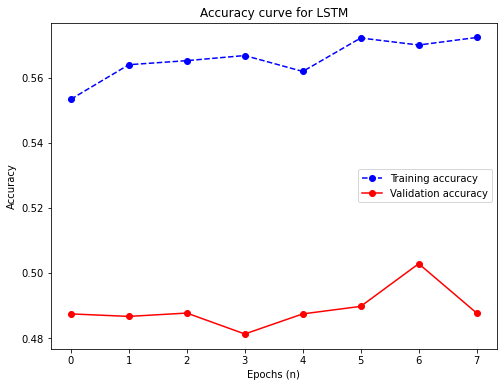

In [37]:
plot_acc(history2)

## 3.2 Performance of model

In [38]:
performance_stats(model, x_train2, y_train2)

Upward ratio: 50.70%
Mean prediction: 50.64%
Predicted upward ratio: 55.27%
Accuracy: 58.99%


In [39]:
performance_stats(model, x_valid2, y_valid2)

Upward ratio: 51.23%
Mean prediction: 47.56%
Predicted upward ratio: 39.66%
Accuracy: 48.77%


In [40]:
performance_stats(model, x_test2, y_test2)

Upward ratio: 46.16%
Mean prediction: 53.36%
Predicted upward ratio: 49.69%
Accuracy: 47.55%


# 4.0 Prepare data for one stock

In [41]:
traditional_energy_stocks[0]

'LNG'

In [42]:
x_train3, y_train3, x_valid3, y_valid3, x_test3, y_test3 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           [traditional_energy_stocks[0]],
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [43]:
print("x_train: {}".format(x_train3.shape))
print("y_train: {}".format(y_train3.shape))
print("x_valid: {}".format(x_valid3.shape))
print("y_valid {}".format(y_valid3.shape))
print("x_test: {}".format(x_test3.shape))
print("y_test {}".format(y_test3.shape))

x_train: (670, 30, 29)
y_train: (670,)
x_valid: (216, 30, 29)
y_valid (216,)
x_test: (217, 30, 29)
y_test (217,)


## 4.1 Train model on less stocks

In [44]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
tensorboard = TensorBoard(log_dir='logs/{}_3'.format(time_stamp))

In [47]:
history3 = model.fit(x_train3, 
                     y_train3, 
                     epochs=5, 
                     validation_data=(x_valid3, y_valid3), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/5
11/11 [==============================] - 10s 670ms/step - loss: 0.6948 - accuracy: 0.5213 - val_loss: 0.7107 - val_accuracy: 0.4722
Epoch 2/5
11/11 [==============================] - 0s 23ms/step - loss: 0.6909 - accuracy: 0.5215 - val_loss: 0.7142 - val_accuracy: 0.4815
Epoch 3/5
11/11 [==============================] - 0s 23ms/step - loss: 0.6920 - accuracy: 0.5084 - val_loss: 0.7094 - val_accuracy: 0.4815
Epoch 4/5
11/11 [==============================] - 0s 24ms/step - loss: 0.6795 - accuracy: 0.5789 - val_loss: 0.7203 - val_accuracy: 0.4815
Epoch 5/5
11/11 [==============================] - 0s 22ms/step - loss: 0.6919 - accuracy: 0.5642 - val_loss: 0.7129 - val_accuracy: 0.4815


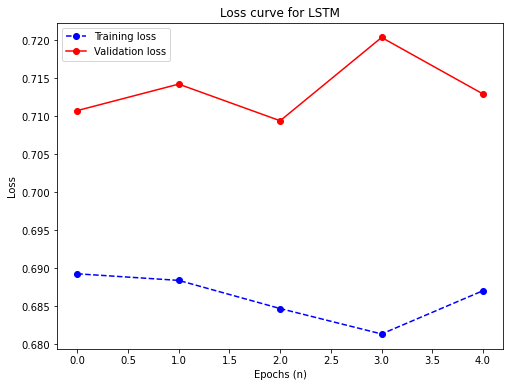

In [48]:
plot_loss(history3)

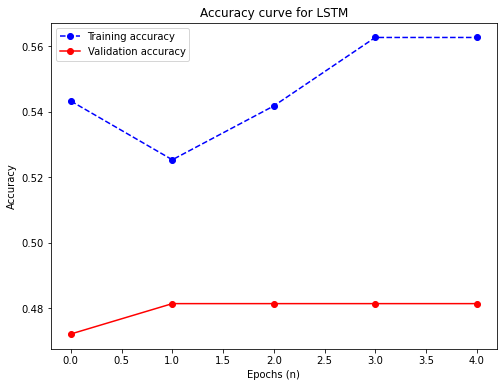

In [49]:
plot_acc(history3)

## 4.2 Performance of model

In [50]:
performance_stats(model, x_train3, y_train3)

Upward ratio: 48.21%
Mean prediction: 49.37%
Predicted upward ratio: 42.39%
Accuracy: 57.76%


In [51]:
performance_stats(model, x_valid3, y_valid3)

Upward ratio: 51.85%
Mean prediction: 44.92%
Predicted upward ratio: 0.00%
Accuracy: 48.15%


In [52]:
performance_stats(model, x_test3, y_test3)

Upward ratio: 44.24%
Mean prediction: 41.55%
Predicted upward ratio: 7.83%
Accuracy: 55.30%
